#  Natural Language Processing

This project is based on the Kaggle competition, "Yelp Business Rating Prediction". In this project, Yelp reviews are classified into star ratings based on the text contents of the reviews.

A Naive Bayes classification model is built using CountVectorizer, TF-IDF transformer, and sklearn Pipeline, and the performance of the model is evaluated using confusion matrix and classification report.





---
#  Exploratory Analysis

##  Import libraries and data

The data is obtained from the Kaggle competition. The data contains the following information.
- Reviews from Yelp users in a text format
- Star ratings of businesses
- Additional columns, 'cool', useful', 'funny' representing votes from other users on the review.

In [1]:
import numpy as np
import pandas as pd

# added to supress "FutureWarning"
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read data
df = pd.read_csv("../data/yelp.csv")

## Describing data

It is always useful to check the head of data and the description before the analysis.

In [3]:
df.head(1)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0


In [4]:
# Basic description of numereical data.
df.describe(include="all")

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
count,10000,10000,10000,10000.000000,10000,10000,10000,10000.000000,10000.000000,10000.000000
unique,4174,1995,10000,NaN,9998,1,6403,NaN,NaN,NaN
top,ntN85eu27C04nwyPa8IHtw,2011-03-28,7yzwfbO6Pwd3ViD9rKbRIA,NaN,This review is for the chain in general. The l...,review,fczQCSmaWF78toLEmb0Zsw,NaN,NaN,NaN
freq,37,21,1,NaN,2,10000,38,NaN,NaN,NaN
mean,NaN,NaN,NaN,3.777500,NaN,NaN,NaN,0.876800,1.409300,0.701300
std,NaN,NaN,NaN,1.214636,NaN,NaN,NaN,2.067861,2.336647,1.907942
min,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000
50%,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,0.000000,1.000000,0.000000
75%,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,1.000000,2.000000,1.000000


The description shows that the data contains 10,000 reviews. There are 4174 businesses with reviews in the data. The date on which most reviews are written was 2011-03-28. There are only two reviews with the same string, telling us that most review texts are unique.

##  Adding "text length" as feature

In natural language processing, often lengths of texts become usuful feature. We can use the built-in function 'len' and apply method to add the text length as a new feature.

In [5]:
df["length"] = df["text"].apply(len)

## Import libraries for visualization

Let's import the libaries for visualization.

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

## Text length and Star rating: FacetGrid

Seaborn provides a useful tool to draw multiple plots on different subsets of the data. We can plot text length for different star ratings to find out if there is any relationship between the text length and start rating.

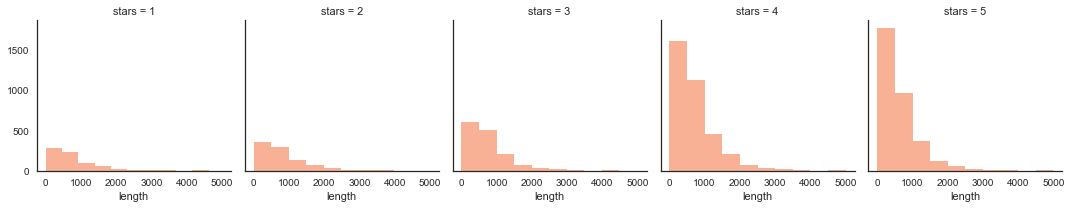

In [7]:
# create FacetGrid
g = sns.FacetGrid(df, col="stars")
ax = g.map(plt.hist,"length", color='#f8b195')

It seems that the reviews with high star ratings tend to have shorter text lengths, but it isn't very clear from these plots since they are not normalized to the same unity. Therefore, we need additional checks to make the same statement.

## Text length and Star rating: Boxplot

Another way to visualize the relationship between text length and star rating is creating a box plot.

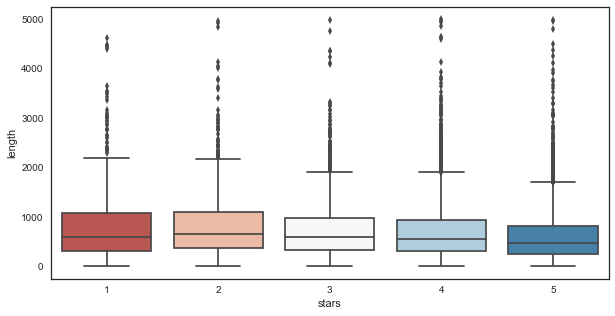

In [8]:
# create subplot
fig, ax = plt.subplots(1,1,figsize=(10,5))

# draw boxplot
sns.boxplot(x="stars", y="length", data=df, palette="RdBu", ax=ax)

## Star rating distribution: countplot

We can also make a countplot to visualize the distribution of star ratings on the entire dataset.

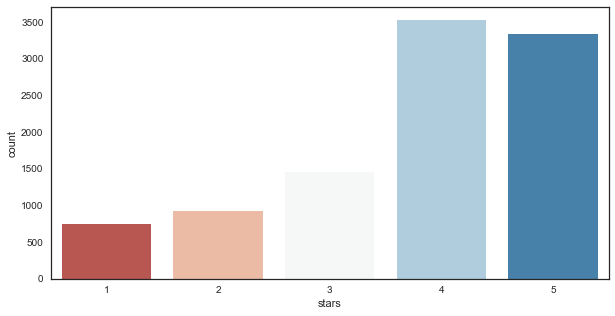

In [9]:
# create figure and subplot
fig, ax = plt.subplots(1,1,figsize=(10,5))

# draw countplot
sns.countplot(x="stars", data=df, palette="RdBu", ax=ax)

## Understanding Vote colums

In addition to star rating, text length, and text contents, the data also provides additional three columns 'cool', 'useful', and 'funny' columns representing votes from other users.

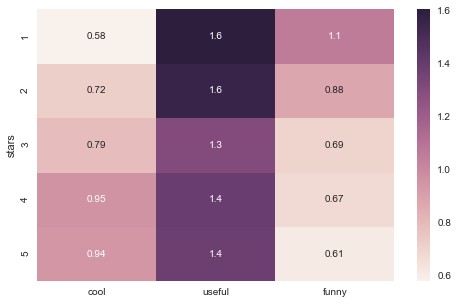

In [10]:
# create subplots
fig, ax = plt.subplots(1,1,figsize=(8,5))

# make heatmap
ax = sns.heatmap(df[["cool","useful","funny","stars"]].groupby("stars").mean(), annot=True)

The mean vote columns for each group of stars shows that 'cool' votes are usually given to the reviews with high star ratings, and 'funny' votes are usually given to the reviews with low star rating. It seems that 'useful' votes are given more to the reviews with low star rating, but the difference is relatively small.

---
# Natural Language Processing Classification

We are going to use sklearn Pipeline and Naive Bayes classifier to process texts and predict star rating from training samples. Let's first split the data into train and test data sets. We will also use the reviews with either 1 or 5 star ratings to make the classification little easier.

## Split data into train and test data sets

In [11]:
# define subset of data
df_subset = df.loc[(df["stars"] == 1) | (df["stars"]==5)]

# check if we only have two star ratings
#df_subset["stars"].nunique()

In [12]:
from sklearn.model_selection import train_test_split

# define "text" as a feature and "stars" as a target variable
X = df_subset["text"]
y = df_subset["stars"]

# split data into train/test data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

## Import libraries related to Natural Language Processing

We are goign to use CountVectorizer to convert lists of strings into lists of vectors (or matrix). We will also use TfidTransformer to calculate TF-IDF for each element of the matrix where TF and IDF are defined as,
- TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)
- IDF(t) = log_e(Total number of documents / Number of documents with term t in it).


Finally, we will import Naive Bayes classifier to make predictions.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

## Using Pipeline to make prediction

Using the vectorizer, TF-IDF transformer, and Naive Bayes classifier, Pipelie allows us to automatically fit and make predictions for star rating without hassles of text preprocessing. Let's import Pipleilne and create an instance.

In [14]:
from sklearn.pipeline import Pipeline

In [15]:
pl = Pipeline([
        ('vectorizer', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('classifier', MultinomialNB()),
])

We can use the pipeline to fit and make prediction as below.

In [16]:
# fit train data set
pl.fit(X_train, y_train)

# make prediction
predictions = pl.predict(X_test)

## Model evaluation

We can use confusion matrix and classification report to evaluate the performance of classification model that we have trained.

In [17]:
from sklearn.metrics import confusion_matrix, classification_report

In [18]:
# producing classification report
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

          1       1.00      0.00      0.01       223
          5       0.82      1.00      0.90      1003

avg / total       0.85      0.82      0.74      1226



The classification report shows that
- All reviews that are predicted to have 1 star rating actually have 1 star rating.
- 82% of reviews that are predicted to have 5 star rating actually have 5 star rating.
- None of true 1 star rating is predicted to be 1 star rating.
- All of true 5 star ratings are predicted to be 1 star rating.

The result looks quite disturbing. In order to understand the situation better, we can also produce a confusion matrix.

In [19]:
# producing confusion matrix
print(confusion_matrix(y_test, predictions))

[[   1  222]
 [   0 1003]]


The confusion matrix tells us why we have suspicious classification report. The classification model actually predicted the most of reviews to be 5 star rating. To confirm this,

In [20]:
predictions.mean()

4.9967373572593798

##  Improving Pipeline model

Given that the poor result from our previous Pipeline, we can try to imporve the model by optimizing the pipeline model. One thing we can try is to produce Pipeline model without TF-IDF transformer.

In [21]:
pl_alt = Pipeline([
        ('vectorizer', CountVectorizer()),
        ('classifier', MultinomialNB()),
])

Repeating the same fit/training procedure,

In [22]:
# fit train data set
pl_alt.fit(X_train, y_train)

# make prediction
predictions = pl_alt.predict(X_test)

print(predictions.mean())

4.41924959217


This time, it seems that the classifier predicts more reviews with star rating 1.

In [23]:
# producing classification report
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

          1       0.84      0.67      0.75       223
          5       0.93      0.97      0.95      1003

avg / total       0.91      0.92      0.91      1226



In [24]:
# producing confusion matrix
print(confusion_matrix(y_test, predictions))

[[150  73]
 [ 28 975]]


Surprisingly, the classification model from Pipeline without any TF-IDF transformer performs better than the previous model. In this model,
- 84% of reviews that are predicted to have 1 star rating actually have 1 star rating.
- 93% of reviews that are predicted to have 5 star rating actually have 5 star rating.
- 67% of true 1 star ratings are predicted to have 1 star rating.
- 97% of true 5 star ratings are predicted to have 5 star rating.

##  Conclusion

In this project, a classification model was built with CountVectorizer, TF-IDF transformer, and Naive Bayes classifier using Pipeline. The performance of the classification model was evaluated, and the model was improved by removing TF-IDF transformer.